In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (10,8)

import statsmodels.formula.api as smf


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn import tree



from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')




# Separación train-test

Evaluar la capacidad predictiva de un modelo consiste en comprobar cómo de próximas son sus predicciones a los verdaderos valores de la variable respuesta, es decir, comparar los predichos frente a los reales. 

Para poder cuantificarlo de forma correcta, se necesita disponer de un conjunto de observaciones, de las que se conozca la variable respuesta, pero que el modelo no haya "visto", es decir, que no hayan participado en su ajuste. Con esta finalidad, se dividen los datos disponibles en un **conjunto de entrenamiento y un conjunto de test**. El tamaño adecuado de las particiones depende en gran medida de la cantidad de datos disponibles y la seguridad que se necesite en la estimación del error, **80%-20% suele dar buenos resultados**. 

Es importante verificar que la distribución de la variable respuesta es similar en el conjunto de entrenamiento y en el de test. Esto lo haremos explorando cada una de las divisiones que hicimos. 

In [2]:
df_limpio = pd.read_csv("data/california_limpio_final.csv", index_col = 0)
df_limpio.head()

,median_home_val,median_household_income,ic2,ic3,ic4,ic5,avggift,x0_AL,x0_AR,x0_AZ,...,x0_NV,x0_OK,x0_OR,x0_SC,x0_TN,x0_TX,x0_WA,x0_WI,x1_F,x1_M
0,1158.437751,392.0,430.0,466.0,520.0,21975.0,10.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,537.000000,365.0,415.0,410.0,473.0,19387.0,5.666667,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,725.000000,301.0,340.0,361.0,436.0,18837.0,4.111111,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1158.437751,401.0,407.0,399.0,413.0,14014.0,10.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,995.000000,252.0,280.0,316.0,348.0,17991.0,6.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [3]:
nuevas_columnas = {
    "ic2" : "num_habitaciones", 
    "ic3": "num_vecinos", 
    "ic4": "total_habitaciones", 
    "ic5": "total_baños", 
    "avggift": "dist_playa"}

df_limpio.rename(columns = nuevas_columnas, inplace = True)

In [4]:
df_limpio.head(2)

,median_home_val,median_household_income,num_habitaciones,num_vecinos,total_habitaciones,total_baños,dist_playa,x0_AL,x0_AR,x0_AZ,...,x0_NV,x0_OK,x0_OR,x0_SC,x0_TN,x0_TX,x0_WA,x0_WI,x1_F,x1_M
0,1158.437751,392.0,430.0,466.0,520.0,21975.0,10.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,537.000000,365.0,415.0,410.0,473.0,19387.0,5.666667,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
# Reparto de datos en train y test
# ==============================================================================
# lo primero que hacemos es definir cual es nuestra variable Y y nuestras variables X
X = df_limpio.drop('median_home_val', axis =1)
y = df_limpio['median_home_val']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size   = 0.8, random_state = 42)

📌 Buena práctica, es recomendable que miremos que los datos del train y del test guarden consistencia estadística. 

In [6]:
print("Datos de entrenamiento")
print("-----------------------")
print(y_train.describe())


Datos de entrenamiento
-----------------------
count    2666.000000
mean      837.409298
std       417.458519
min       128.000000
25%       544.250000
50%       759.000000
75%      1022.250000
max      2135.000000
Name: median_home_val, dtype: float64


In [7]:
print("Datos de testeo")
print("-----------------------")
print(y_test.describe())


Datos de testeo
-----------------------
count     667.000000
mean      842.272677
std       415.190356
min       139.000000
25%       543.000000
50%       770.000000
75%      1016.000000
max      2132.000000
Name: median_home_val, dtype: float64


# Ajustamos el modelo


Podremos hacerlo de dos formas: 

- Usando la librería **statsmodels**


- Usando la librería **sklearn**

¿En que se diferencian estos dos métodos?

En esencia ninguna. Sin embargo, el modelo de `statsmodels` sigue la aproximación más tradicional en la que vamos a querer saber que variables "explican" o afectan más a la variable respuesta a través de los *p-valores*. Por otro lado, sigue la aproximación de aprendizaje automático donde lo importante el principal objetivo es elegir el mejor modelo. 

## Antes de empezar entendamos mejor que es una regresión lineal

De un modo general se dice que existe regresión de los valores de una variable con respecto a los de la otra cuando hay alguna línea, denominada línea de regresión, que se ajusta más o menos claramente a los valores observados. La regresión se usa para la identificación de relaciones potencialmente causales o bien, cuando no existen dudas sobre su relación causal, para predecir una variable a partir de la otra. 

![regresion](https://github.com/Ironhack-Part-Time-Enero2022/apuntes-clases/blob/master/semana-17/imagenes/regresion.png?raw=true)

In [8]:
# pendiente
beta_1 = 0.4

# intercepto
beta_0 = 12

# n casas
num_points = 100

# numero habitaciones
X = np.random.normal(5, 1, num_points)  

In [9]:
# random error
random_error = np.random.normal(loc=0, scale=0.2, size=num_points)

# mark
y = beta_0 + (beta_1 * X) + random_error

data = pd.DataFrame({
    'habitaciones': X,
    'precio': y})

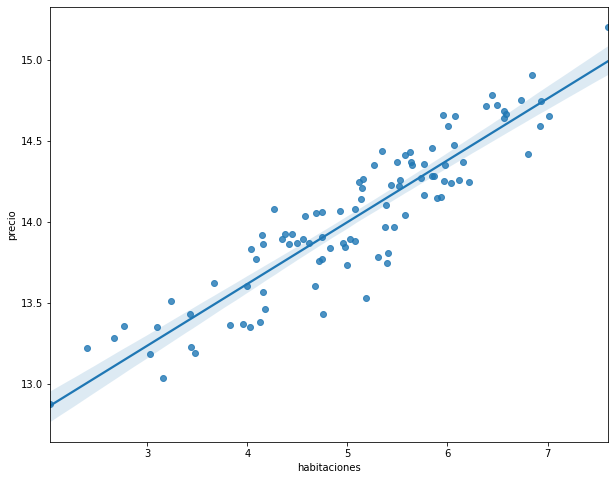

In [10]:
sns.regplot(data=data, x = "habitaciones", y = "precio");

## Usando la librería stats

En este caso usaremos el dataframe sin codificar las variables categóricas ya que este método si nos permite pasarle variables de tipo *string* 

In [11]:
df = pd.read_csv("data/california_limpio1.csv", index_col = 0)
df.head(2)

,state,gender,median_home_val,median_household_income,ic2,ic3,ic4,ic5,avggift
0,FL,M,1158.437751,392.0,430.0,466.0,520.0,21975.0,10.000000
1,IL,M,537.000000,365.0,415.0,410.0,473.0,19387.0,5.666667


In [12]:
nuevas_columnas = {
    "median_household_income": "renta", 
    "ic2": "num_habitantes", 
    "ic3": "num_vecinos", 
    "ic4": "total_habitaciones", 
    "ic5": "total_baños", 
    "avggift": "dist_playa"
}

df.rename(columns = nuevas_columnas, inplace = True)

In [13]:
df.head(2)

,state,gender,median_home_val,renta,num_habitantes,num_vecinos,total_habitaciones,total_baños,dist_playa
0,FL,M,1158.437751,392.0,430.0,466.0,520.0,21975.0,10.000000
1,IL,M,537.000000,365.0,415.0,410.0,473.0,19387.0,5.666667


In [14]:
# fit ols model with categorical variables


In [15]:
results = smf.ols("median_home_val ~  gender +  state +  renta + num_habitantes + num_vecinos + total_habitaciones + total_baños + dist_playa", data=df).fit() 
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        median_home_val   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     85.98
Date:                Sat, 07 May 2022   Prob (F-statistic):               0.00
Time:                        00:18:28   Log-Likelihood:                -23779.
No. Observations:                3333   AIC:                         4.763e+04
Df Residuals:                    3298   BIC:                         4.784e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -68.2228     45.895     -1.486      0.137    -158.209      21.764
gender[T.M]           -6.2223     10.850     -0.573      0.566     -27.496      15.051
state[T.AR]           67.6170     57.747      1.171      0.242     -45.606     180.840
state[T.AZ]          256.1494     52.778      4.853      0.000     152.668     359.630
state[T.CA]          476.4207     42.863     11.115      0.000     392.379     560.462
state[T.CO]          186.5126     53.172      3.508      0.000      82.259     290.766
state[T.FL]          234.8116     44.418      5.286      0.000     147.722     321.901
state[T.GA]           83.7211     50.214      1.667      0.096     -14.733     182.175
state[T.IA]         -102.6836     61.888     -1.659      0.097    -224.027      18.660
state[T.IL]          167.9482     45.696      3.675      0.000      78.352     257.544
state[T.IN]          -14.5427     50.972     -0.285      0.775    -114.482      85.397
state[T.KS]          -21.0724     60.757     -0.347      0.729    -140.197      98.052
state[T.KY]           43.6203     56.116      0.777      0.437     -66.406     153.646
state[T.LA]          122.6107     59.396      2.064      0.039       6.153     239.068
state[T.MI]           -4.8405     45.879     -0.106      0.916     -94.795      85.114
state[T.MN]           35.2390     54.722      0.644      0.520     -72.054     142.532
state[T.MO]           63.1089     50.875      1.240      0.215     -36.642     162.860
state[T.MS]           18.4747     67.761      0.273      0.785    -114.383     151.333
state[T.NC]          126.0150     47.533      2.651      0.008      32.818     219.212
state[T.NE]          -62.4889     67.701     -0.923      0.356    -195.230      70.252
state[T.NM]          225.2382     62.372      3.611      0.000     102.946     347.531
state[T.NV]          317.3479     61.245      5.182      0.000     197.266     437.430
state[T.OK]            3.2505     58.249      0.056      0.956    -110.958     117.459
state[T.OR]          114.0160     50.448      2.260      0.024      15.103     212.928
state[T.SC]           78.2518     53.764      1.455      0.146     -27.163     183.666
state[T.TN]           53.9920     59.452      0.908      0.364     -62.574     170.558
state[T.TX]           74.7266     44.879      1.665      0.096     -13.267     162.720
state[T.WA]          308.2957     48.267      6.387      0.000     213.659     402.932
state[T.WI]           47.5112     50.771      0.936      0.349     -52.035     147.057
renta                 -0.0035      0.130     -0.027      0.979      -0.259       0.252
num_habitantes         0.4494      0.139      3.223      0.001       0.176       0.723
num_vecinos            0.4327      0.145      2.985      0.003       0.148       0.717
total_habitaciones     0.5084      0.1

Interpretemos los resultados: 

- **coef**: es el coeficiente que representa los cambios medios en la variable respuesta para una unidad de cambio en la variable predictora mientras se mantienen constantes el resto de las variables predictoras. Es la pendiente! 


- **std err**: es el error estándar del coeficiente. Se usa para medir la precisión de la estimación del coeficiente. Cuanto menor sea el error estándar, más precisa será la estimación. 


- **t** : es el resultado de dicivir el coeficiente entre su error estándar 


- **P**: corresponde con el *p-valor*. Este valor es que usaremos para decidir si una variable tiene efecto significativo sobre nuestra variable respuesta o no, de esta forma: 

    - p-valor < 0.05 esa variable tiene un efecto significativo sobre el precio de las casas. Afecta al precio de la casa
    
    - p-valor > 0.05 esa variable NO tiene un efecto significativo sobre el precio de las casas. 
   
   
- **R-squared**: el porcentaje de la variación de la variable respuesta está explicado por nuestro modelo. Es decir, nuestros datos explican 31.6% de la variación en los precios de las casas. 


In [16]:
results2 = smf.ols("median_home_val ~  gender + num_vecinos + total_habitaciones + total_baños + dist_playa", data=df).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        median_home_val   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     306.6
Date:                Sat, 07 May 2022   Prob (F-statistic):          1.61e-270
Time:                        00:18:28   Log-Likelihood:                -24205.
No. Observations:                3333   AIC:                         4.842e+04
Df Residuals:                    3327   BIC:                         4.846e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -20.2998     26.322     -0.771      0.441     -71.910      31.310
gender[T.M]          -26.3155     12.197     -2.158      0.031     -50.230      -2.401
num_vecinos            0.9259      0.123      7.523      0.000       0.685       1.167
total_habitaciones     0.6399      0.127      5.037      0.000       0.391       0.889
total_baños            0.0155      0.002      7.026      0.000       0.011       0.020
dist_playa             3.6666      1.408      2.605      0.009       0.907       6.426
==============================================================================
Omnibus:                      853.448   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1894.673
Skew:                           1.458   Prob(JB):                         0.00
Kurtosis:                       5.268   Cond. No.                     6.58e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Usando la librería sklearn

Se ajusta un primer modelo de regresión lineal con regularización LinearRegression para predecir el precio de la vivienda en función de todos los predictores disponibles. 

Necesitaremos importar:

```python
from sklearn.linear_model import LinearRegression

```

In [17]:
# iniciamos el método de Linear Regression
lr = LinearRegression()

In [18]:
# es el momento de ajustar el modelo. Para eso usaremos el método .fit() donde le tendremos que pasar las variables predictoras y la respuesta

lr.fit(X_train, y_train)

LinearRegression()

In [19]:
lr.intercept_

30.86252988115814

In [20]:
lr.coef_

array([ 3.48848559e-02,  5.70647972e-01,  3.63889794e-01,  4.66446522e-01,
        1.23421585e-02,  6.12997177e-01, -9.83022226e+01, -3.30444013e+01,
        1.47633970e+02,  3.67904949e+02,  8.60432018e+01,  1.32302779e+02,
       -1.74513426e+01, -2.09900256e+02,  6.89707338e+01, -1.32003165e+02,
       -1.26818947e+02, -3.79210690e+01,  1.28901752e+01, -1.08370822e+02,
       -6.41596348e+01, -4.39098381e+01, -7.91214581e+01,  3.44637633e+01,
       -1.58558229e+02,  1.21295501e+02,  2.25110560e+02, -1.21373163e+02,
        2.43861559e+00, -1.64364481e+01, -4.43236900e+01, -3.45520046e+01,
        1.97271541e+02, -7.00790979e+01,  2.15345252e+00, -2.15345252e+00])

# Predicción

Una vez que el modelo ha sido entrenado, con el método `.predict()` se pueden predecir nuevas observaciones. 

Veamos como hacerlo:



In [21]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

In [22]:
train_df = pd.DataFrame({'Real': y_train, 'Predicted': y_pred_train, 'Set': ['Train']*len(y_train)})
test_df  = pd.DataFrame({'Real': y_test,  'Predicted': y_pred,  'Set': ['Test']*len(y_test)})
results = pd.concat([train_df,test_df], axis = 0)
results.head()

,Real,Predicted,Set
817,953.0,819.592019,Train
1373,986.0,1131.185550,Train
679,684.0,895.314565,Train
56,927.0,686.312332,Train
1993,1398.0,849.105885,Train


In [23]:
results['residual'] = results['Real'] - results['Predicted']
results.head()

,Real,Predicted,Set,residual
817,953.0,819.592019,Train,133.407981
1373,986.0,1131.185550,Train,-145.185550
679,684.0,895.314565,Train,-211.314565
56,927.0,686.312332,Train,240.687668
1993,1398.0,849.105885,Train,548.894115


**Pero... ¿qué son los residuos?** 

> Los residuos (o errores) son la diferencia entre los valores observados y los valores que predice el modelo:


Los residuos pueden ser nulos, positivos o negativos. 

- Si son nulos entonces no existe ningún error en la estimación, ya que, los valores observados coinciden con los valores estimados. 


- Si es positivo entonces el valor observado de Y es mayor que el valor estimado lo que implica que se infraestima la variable Y, en nuestro caso el precio de las casas.


- Si el residuo es negativo entonces el valor observado de Y es menor que su valor estimado y por lo tanto se sobreestima la variable Y, en nuestro caso el precio de las casas

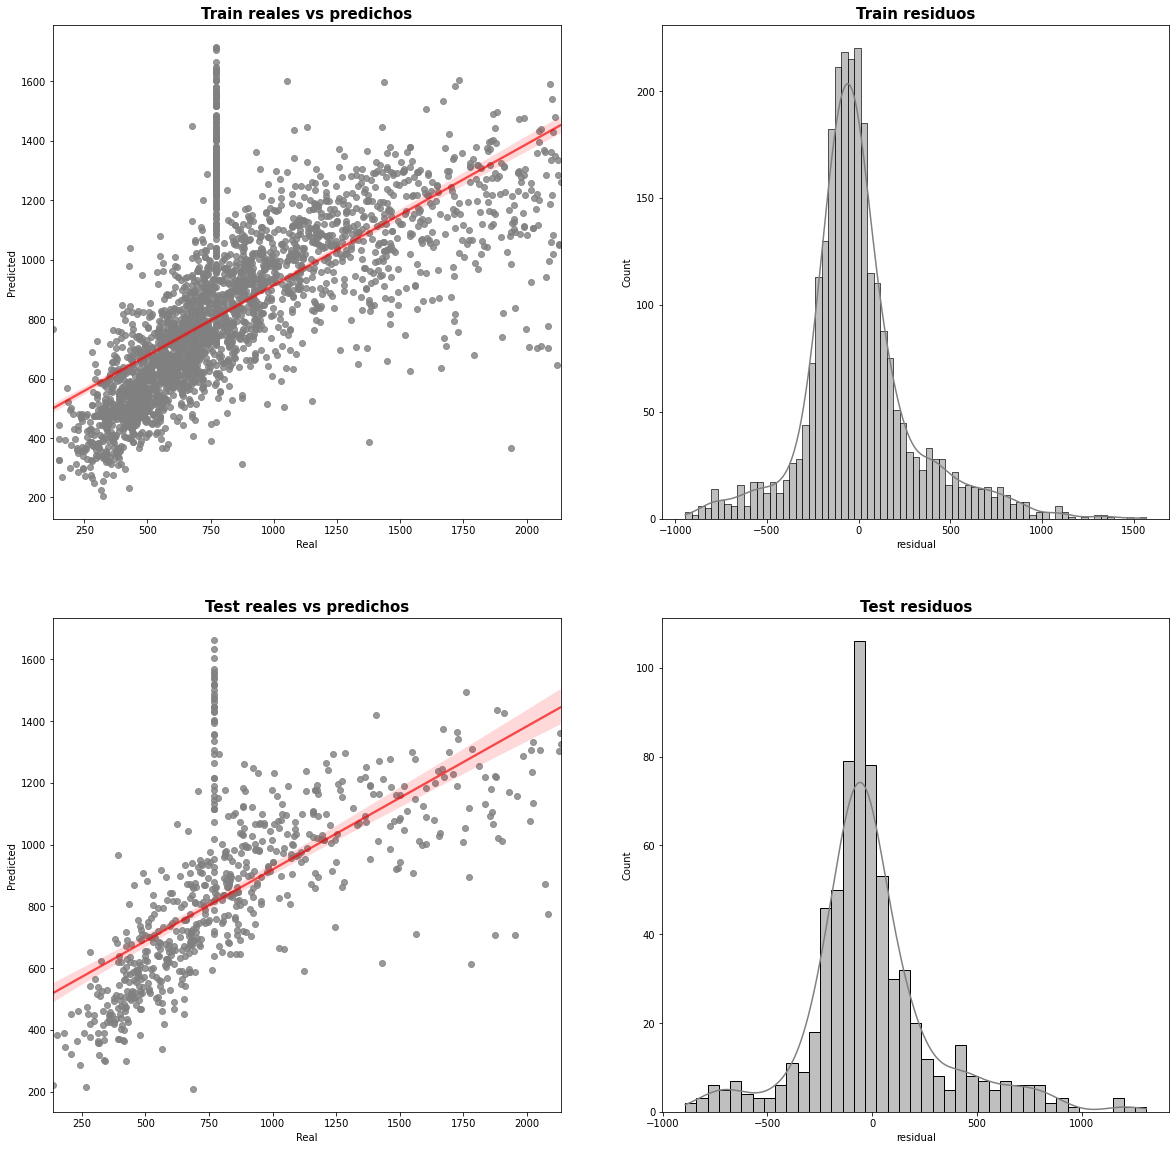

In [24]:
fig, ax = plt.subplots(2,2,figsize=(20,20))


# ploteamos los reales vs los predichos
sns.regplot(data = results[results['Set'] == "Train"], 
            x = "Real", 
            y = "Predicted", 
            ax = ax[0,0], 
            color = "grey",
            line_kws = {"color": "red", "alpha": 0.7 })


sns.regplot(data = results[results['Set'] == "Test"], 
            x = "Real",
            y = "Predicted", 
            color = "gray",
            line_kws = {"color": "red", "alpha": 0.7 }, 
            ax = ax[1,0])


# ploteamos los residuos
sns.histplot(results[results['Set'] == "Train"],
             x="residual",
             color ="grey",
             kde=True, 
             ax = ax[0,1])


sns.histplot(results[results['Set'] == "Test"],
             x="residual",
             color = "grey",
             kde=True, 
             ax = ax[1,1])

ax[0,0].set_title("Train reales vs predichos", fontsize = 15, fontweight = "bold")
ax[0,1].set_title("Train residuos", fontsize = 15, fontweight = "bold")
ax[1,0].set_title("Test reales vs predichos", fontsize = 15, fontweight = "bold")
ax[1,1].set_title("Test residuos", fontsize = 15, fontweight = "bold");

# Validación del modelo

La finalidad última de un modelo es predecir la variable respuesta en observaciones futuras o en observaciones que el modelo no ha “visto” antes, es decir, los datos que tenemos en el test. El error mostrado por defecto tras entrenar un modelo suele ser el error de entrenamiento, el error que comete el modelo al predecir las observaciones que ya ha “visto”. 

Si bien el análisis de los residuos son útiles para entender cómo está aprendiendo el modelo, no es una estimación realista de cómo se comporta el modelo ante nuevas observaciones. 

Las métricas que usaremos para evaluar lo bueno que es nuestro modelo son: 

- Error medio cuadrado (**MSE**): es quizás la métrica más simple y común para la evaluación de regresión, pero también es probablemente la menos útil. Se define por la ecuación.


    - Se resta la diferencia entre el valor predicho y el valor real y se eleva al cuadrado.
    - Se suman todos los resultados del punto anterior.
    - Se divide el valor de la suma entre la cantidad de puntos pronosticados.


   ![MSE](https://github.com/Ironhack-Part-Time-Enero2022/apuntes-clases/blob/master/semana-17/imagenes/MSE.png?raw=true)

    Básicamente mide el error cuadrado promedio de nuestras predicciones. Para cada punto, calcula la diferencia cuadrada entre las predicciones y el valor real y luego promedia esos valores.
    
    

- Error cuadrático medio (**RMSE**): es solo la raíz cuadrada de MSE. La raíz cuadrada se introduce para hacer que la escala de los errores sea igual a la escala de los objetivos.


    - Se resta la diferencia entre el valor predicho y el valor real y se eleva al cuadrado.
    - Se suman todos los resultados del punto anterior.
    - Se divide el valor de la suma entre la cantidad de puntos pronosticados.
    - Se saca la raíz cuadrada del resultado del punto anterior.
    
   ![rmse](https://github.com/Ironhack-Part-Time-Enero2022/apuntes-clases/blob/master/semana-17/imagenes/rmse.jpeg?raw=true)


    Es una media que representa la raíz cuadrada del segundo momento de las diferencias. Entre mayor el resultado mayor es el error y menos preciso el modelo.

- Error absoluto medio (**MAE**): es un promedio de los errores del modelo. Se obtiene un número, un valor alto representa un error alto. 


    - Se resta la diferencia entre el valor predicho y el valor real en cada punto que se pronostica.
    - Se saca el valor absoluto del punto anterior.
    - Se suman todos los resultados del punto anterior.
    - Se divide el valor de la suma entre la cantidad de puntos pronosticados.
    
   ![MAE](https://github.com/Ironhack-Part-Time-Enero2022/apuntes-clases/blob/master/semana-17/imagenes/mae.png?raw=true)
    
    
    Es una medida que tiene un sesgo hacia items de mayor volumen y normalmente es inadecuado para medir ítems con baja demanda


- R cuadrado (**R2**): nos dice qué porcentaje de variación de la variable predictora es explicado por todas las variables predictoras. Oscila entre 0 y 1. Cuanto más cerca de 1 se sitúe su valor, mayor será el ajuste del modelo a la variable que estamos intentando explicar. 

- R cuadrado ajustado (**R2 ajd**): es lo mismo que el R2, pero en este caso se penalizará cada variable que se incluye en el modelo. 

In [25]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("R2:",  metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 209.68335501501392
Mean Squared Error: 94927.5423528897
Root Mean Squared Error: 308.103135902395
R2: 0.4484951606501252


Ahora vamos a introducir los conceptos de *overfitting* y *underfitting*. Para hacerlo tendremos que comparar las métricas de evaluación tanto del train como del test. 

![over](https://github.com/Ironhack-Part-Time-Enero2022/apuntes-clases/blob/master/semana-17/imagenes/overfitting-underfitting.png?raw=true=)

Deberemos encontrar un punto medio en el aprendizaje de nuestro modelo en el que no estemos incurriendo en underfitting y tampoco en overfitting. A veces esto puede resultar una tarea muy difícil. Vamos a ello:  

In [26]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, y_pred_train))
print('Mean Squared Error:', metrics.mean_squared_error(y_train, y_pred_train))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print("R2:",  metrics.r2_score(y_train, y_pred_train))

Mean Absolute Error: 207.26915176208482
Mean Squared Error: 91563.79133652324
Root Mean Squared Error: 302.59509470003513
R2: 0.474394329076514


In [27]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)]}
    
    df = pd.DataFrame(resultados, index = ["test", "train"])
    df["modelo"] = tipo_modelo
    return df
    
    

In [28]:
lr_results = metricas(y_test, y_train, y_pred, y_pred_train, "Regresion lineal")

In [29]:
lr_results

,MAE,MSE,RMSE,R2,modelo
test,209.683355,94927.542353,308.103136,0.448495,Regresion lineal
train,207.269152,91563.791337,302.595095,0.474394,Regresion lineal


In [30]:
lr_results.style.background_gradient(cmap='coolwarm')

,MAE,MSE,RMSE,R2,modelo
test,209.683355,94927.542353,308.103136,0.448495,Regresion lineal
train,207.269152,91563.791337,302.595095,0.474394,Regresion lineal


Una vez que tenemos las métricas de los dos conjuntos de datos, ¿cómo sabremos si tener *overfitting*, *underfitting* o nada de eso?

- Si los valores del train son MUCHO MEJOR (que es tener métricas más bajas) que los del test --> **overfitting**. En este caso, nuestro modelo se estaría aprendiendo de memoria los datos de entrenamiento y no sería capaz de hacer buenas predicciones fuera de ese set de datos. 


- Si los valores del train son MUCHO PEOR (valores de las métricas más altas) que los del test --> **underfitting**. En este caso, nuestro modelo no es lo suficientemente bueno para generalizar a los datos de test ni para modelar decentemente los del train. 

## Cross validation

Lo que hacemos normalmente al entrenar el modelo es pasarle todos los registros del train y que haga el fit(). Con K-Folds en vez de pasarle todos los registros directamente al modelo, haremos así:

Iterar 5 veces:


- Apartaremos 1/5 de muestras.


- Entrenamos al modelo con el restante 4/5 de muestras.


- Mediremos el accuracy obtenido sobre las muestras que habíamos apartado.


- Esto quiere decir que hacemos 5 entrenamientos independientes.


Lo bueno que es nuestro modelo final será el promedio de las 5 metricas anteriores.


![cross](https://raw.githubusercontent.com/Ironhack-Part-Time-Enero2022/apuntes-clases/c413cb29355dd631eead12f89ffbf76dac71bc61/semana-17/imagenes/cross_val.svg)


Los principales métodos que tenemos son: 

- `cross_val_score`

- `cross_validate`

> La principal diferencia entre estos dos métodos es que el segundo nos permite testar distintas métricas. 

In [31]:
# Validación cruzada repetida con una única métrica
# ==============================================================================
cv_scores = cross_val_score(
                estimator = LinearRegression(),
                X         = X,
                y         = y,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 10
             )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [nan nan nan nan nan nan nan nan nan nan]
Média métricas de validación cruzada: nan


In [32]:
# qué métricas podemos usar
# ==============================================================================
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [33]:
# Validación cruzada repetida con múltiples métricas
# ==============================================================================

cv_scores = cross_validate(
                estimator = LinearRegression(),
                X         = X,
                y         = y,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = 10)

# Se convierte el diccionario a dataframe para facilitar la visualización
cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_r2,test_neg_root_mean_squared_error
0,0.001284,0.0,NaN,NaN
1,0.001201,0.0,NaN,NaN
2,0.001329,0.0,NaN,NaN
3,0.001367,0.0,NaN,NaN
4,0.001069,0.0,NaN,NaN
5,0.000995,0.0,NaN,NaN
6,0.001350,0.0,NaN,NaN
7,0.001818,0.0,NaN,NaN
8,0.002382,0.0,NaN,NaN
9,0.002273,0.0,NaN,NaN


# Otros modelos

A veces nos podemos encontrar con que nuestro modelo de Regresión Lineal no es muy bueno. Para mejorar el modelo, podemos pensar en Tunear sus parámetros y volver a entrenar y probar, podemos intentar obtener más registros, cambiar el preprocesado de datos, limpieza, balanceo de clases, selección de features, generación de features… De hecho, podemos pensar que seleccionamos un mal modelo, y podemos intentar con distintos modelos: de árbol de decisión, redes neuronales, ensambles…

En este apartado veremos otros tipos de modelos de regresión que podemos aplicar en Python

## Decision Tree

Crear un árbol de decisiones es en un proceso de dividir los datos de entrada, este es un procedimiento numérico en el que se alinean todos los valores y se prueban diferentes puntos de división utilizando distintos métodos. Todas las variables de entrada y todos los puntos de división posibles se evalúan y se elige la que tenga mejor resultado.

> A diferencia de los modelos lineales, los árboles de decisiones pueden capturar la interacción no lineal entre las características y el objetivo.

Los árboles de decisión son modelos predictivos formados por reglas binarias (si/no) con las que se consigue repartir las observaciones en función de sus atributos y predecir así el valor de la variable respuesta.

Muchos métodos predictivos generan modelos globales en los que una única ecuación se aplica a todo el espacio muestral. Cuando el caso de uso implica múltiples predictores, que interaccionan entre ellos de forma compleja y no lineal, es muy difícil encontrar un único modelo global que sea capaz de reflejar la relación entre las variables. Los métodos estadísticos y de machine learning basados en árboles engloban a un conjunto de técnicas supervisadas no paramétricas que consiguen segmentar el espacio de los predictores en regiones simples, dentro de las cuales es más sencillo manejar las interacciones. Es esta característica la que les proporciona gran parte de su potencial.
![dt](https://github.com/Ironhack-Part-Time-Enero2022/apuntes-clases/blob/master/semana-17/imagenes/decission-tree.png?raw=true)
DecisionTreeRegressor tiene por defecto los siguientes hiperparámetros:

- criterion='mse'


- splitter='best'


- max_depth=None


- min_samples_split=2


- min_samples_leaf=1


- min_weight_fraction_leaf=0.0


- max_features=None


- random_state=None


- max_leaf_nodes=None


- min_impurity_decrease=0.0


- min_impurity_split=None


- ccp_alpha=0.0


De entre todos ellos, los más importantes son aquellos que detienen el crecimiento del árbol (condiciones de stop):

- `max_depth`: profundidad máxima que puede alcanzar el árbol.


- `min_samples_split`: número mínimo de observaciones que debe de tener un nodo para que pueda dividirse. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).


- `min_samples_leaf`: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).


- `max_leaf_nodes`: número máximo de nodos terminales.


- `random_state`: semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.



### Ajustamos el modelo

In [34]:
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

Una vez entrenado el árbol, se puede representar mediante la combinación de las funciones plot_tree(). La función plot_tree() dibuja la estructura del árbol y muestra el número de observaciones y valor medio de la variable respuesta en cada nodo.

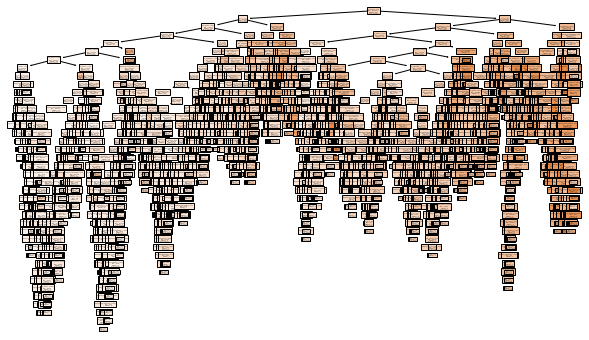

In [35]:
fig = plt.figure(figsize=(10, 6))
tree.plot_tree(regressor, feature_names=X_train.columns, filled=True)
plt.show();


Esto no hay quien lo entienda, lo que nos hace pensar que dejar los parámetros por defecto no es una buena idea. Pero entonces como lo podemos hacer? En Python tenemos el método `GridSearchCV` que nos va a permitir crear un modelo con varias combinaciones de hiperparámetros. Veamos como hacerlo: 

### Ajustamos el modelo usando el GridSearch

In [36]:
# Generación del GridSearch
# ==============================================================================

# definimos un diccionario con los hiperparámetros que queremos testear. 
param = {"max_depth": [4, 5, 6, 7],
        "min_samples_split": [10, 50, 100, 300],
        "max_features": [7, 11]}

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(),
            param_grid= param,
            cv=10,
            verbose=3,
            return_train_score = True,
            scoring="neg_mean_squared_error")


In [37]:
# ajustamos el modelo de nuevo

%time
gs.fit(X_train, y_train)



CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs
Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] max_depth=4, max_features=7, min_samples_split=10 ...............
[CV]  max_depth=4, max_features=7, min_samples_split=10, score=(train=-93209.814, test=-100977.760), total=   0.0s
[CV] max_depth=4, max_features=7, min_samples_split=10 ...............
[CV]  max_depth=4, max_features=7, min_samples_split=10, score=(train=-119947.110, test=-116342.799), total=   0.0s
[CV] max_depth=4, max_features=7, min_samples_split=10 ...............
[CV]  max_depth=4, max_features=7, min_samples_split=10, score=(train=-90760.102, test=-109620.072), total=   0.0s
[CV] max_depth=4, max_features=7, min_samples_split=10 ...............
[CV]  max_depth=4, max_features=7, min_samples_split=10, score=(train=-98202.809, test=-107593.865), total=   0.0s
[CV] max_depth=4, max_features=7, min_samples_split=10 ...............
[CV]  max_depth=4, max_features=7, min_samples_split=10, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=4, max_features=7, min_samples_split=100, score=(train=-102478.666, test=-120916.467), total=   0.0s
[CV] max_depth=4, max_features=7, min_samples_split=100 ..............
[CV]  max_depth=4, max_features=7, min_samples_split=100, score=(train=-97785.749, test=-102580.990), total=   0.0s
[CV] max_depth=4, max_features=7, min_samples_split=100 ..............
[CV]  max_depth=4, max_features=7, min_samples_split=100, score=(train=-89964.328, test=-93203.806), total=   0.0s
[CV] max_depth=4, max_features=7, min_samples_split=100 ..............
[CV]  max_depth=4, max_features=7, min_samples_split=100, score=(train=-105796.160, test=-110161.322), total=   0.0s
[CV] max_depth=4, max_features=7, min_samples_split=100 ..............
[CV]  max_depth=4, max_features=7, min_samples_split=100, score=(train=-97628.858, test=-99434.527), total=   0.0s
[CV] max_depth=4, max_features=7, min_samples_split=100 ..............
[CV]  max_depth=4, max_features=7, min_samples_split=100, score=(

[CV]  max_depth=4, max_features=11, min_samples_split=100, score=(train=-92893.528, test=-104525.675), total=   0.0s
[CV] max_depth=4, max_features=11, min_samples_split=100 .............
[CV]  max_depth=4, max_features=11, min_samples_split=100, score=(train=-105634.560, test=-87297.088), total=   0.0s
[CV] max_depth=4, max_features=11, min_samples_split=100 .............
[CV]  max_depth=4, max_features=11, min_samples_split=100, score=(train=-109741.891, test=-114277.050), total=   0.0s
[CV] max_depth=4, max_features=11, min_samples_split=100 .............
[CV]  max_depth=4, max_features=11, min_samples_split=100, score=(train=-114460.865, test=-132412.455), total=   0.0s
[CV] max_depth=4, max_features=11, min_samples_split=100 .............
[CV]  max_depth=4, max_features=11, min_samples_split=100, score=(train=-102018.499, test=-114459.099), total=   0.0s
[CV] max_depth=4, max_features=11, min_samples_split=300 .............
[CV]  max_depth=4, max_features=11, min_samples_split=300

[CV]  max_depth=5, max_features=7, min_samples_split=300, score=(train=-97772.947, test=-103306.343), total=   0.0s
[CV] max_depth=5, max_features=7, min_samples_split=300 ..............
[CV]  max_depth=5, max_features=7, min_samples_split=300, score=(train=-84728.260, test=-89476.654), total=   0.0s
[CV] max_depth=5, max_features=7, min_samples_split=300 ..............
[CV]  max_depth=5, max_features=7, min_samples_split=300, score=(train=-115393.491, test=-94760.485), total=   0.0s
[CV] max_depth=5, max_features=7, min_samples_split=300 ..............
[CV]  max_depth=5, max_features=7, min_samples_split=300, score=(train=-92422.513, test=-83503.732), total=   0.0s
[CV] max_depth=5, max_features=7, min_samples_split=300 ..............
[CV]  max_depth=5, max_features=7, min_samples_split=300, score=(train=-100387.507, test=-132769.227), total=   0.0s
[CV] max_depth=5, max_features=7, min_samples_split=300 ..............
[CV]  max_depth=5, max_features=7, min_samples_split=300, score=(t

[CV]  max_depth=5, max_features=11, min_samples_split=300, score=(train=-103196.095, test=-112309.306), total=   0.0s
[CV] max_depth=6, max_features=7, min_samples_split=10 ...............
[CV]  max_depth=6, max_features=7, min_samples_split=10, score=(train=-90521.742, test=-113180.938), total=   0.0s
[CV] max_depth=6, max_features=7, min_samples_split=10 ...............
[CV]  max_depth=6, max_features=7, min_samples_split=10, score=(train=-87275.718, test=-81444.438), total=   0.0s
[CV] max_depth=6, max_features=7, min_samples_split=10 ...............
[CV]  max_depth=6, max_features=7, min_samples_split=10, score=(train=-81757.990, test=-94313.276), total=   0.0s
[CV] max_depth=6, max_features=7, min_samples_split=10 ...............
[CV]  max_depth=6, max_features=7, min_samples_split=10, score=(train=-109402.857, test=-128468.829), total=   0.0s
[CV] max_depth=6, max_features=7, min_samples_split=10 ...............
[CV]  max_depth=6, max_features=7, min_samples_split=10, score=(trai

[CV]  max_depth=6, max_features=11, min_samples_split=10, score=(train=-93125.237, test=-128232.305), total=   0.0s
[CV] max_depth=6, max_features=11, min_samples_split=10 ..............
[CV]  max_depth=6, max_features=11, min_samples_split=10, score=(train=-85040.009, test=-111628.831), total=   0.0s
[CV] max_depth=6, max_features=11, min_samples_split=50 ..............
[CV]  max_depth=6, max_features=11, min_samples_split=50, score=(train=-95991.450, test=-119886.223), total=   0.0s
[CV] max_depth=6, max_features=11, min_samples_split=50 ..............
[CV]  max_depth=6, max_features=11, min_samples_split=50, score=(train=-93444.173, test=-96704.964), total=   0.0s
[CV] max_depth=6, max_features=11, min_samples_split=50 ..............
[CV]  max_depth=6, max_features=11, min_samples_split=50, score=(train=-93112.263, test=-106386.189), total=   0.0s
[CV] max_depth=6, max_features=11, min_samples_split=50 ..............
[CV]  max_depth=6, max_features=11, min_samples_split=50, score=(t

[CV]  max_depth=7, max_features=7, min_samples_split=50, score=(train=-95759.598, test=-118700.813), total=   0.0s
[CV] max_depth=7, max_features=7, min_samples_split=50 ...............
[CV]  max_depth=7, max_features=7, min_samples_split=50, score=(train=-90004.979, test=-119745.780), total=   0.0s
[CV] max_depth=7, max_features=7, min_samples_split=50 ...............
[CV]  max_depth=7, max_features=7, min_samples_split=50, score=(train=-84069.496, test=-102066.186), total=   0.0s
[CV] max_depth=7, max_features=7, min_samples_split=50 ...............
[CV]  max_depth=7, max_features=7, min_samples_split=50, score=(train=-83453.226, test=-88238.750), total=   0.0s
[CV] max_depth=7, max_features=7, min_samples_split=50 ...............
[CV]  max_depth=7, max_features=7, min_samples_split=50, score=(train=-96307.253, test=-78961.815), total=   0.0s
[CV] max_depth=7, max_features=7, min_samples_split=50 ...............
[CV]  max_depth=7, max_features=7, min_samples_split=50, score=(train=-1

[CV]  max_depth=7, max_features=11, min_samples_split=50, score=(train=-70633.587, test=-100825.464), total=   0.0s
[CV] max_depth=7, max_features=11, min_samples_split=50 ..............
[CV]  max_depth=7, max_features=11, min_samples_split=50, score=(train=-75812.609, test=-91358.918), total=   0.0s
[CV] max_depth=7, max_features=11, min_samples_split=100 .............
[CV]  max_depth=7, max_features=11, min_samples_split=100, score=(train=-77059.995, test=-93567.384), total=   0.0s
[CV] max_depth=7, max_features=11, min_samples_split=100 .............
[CV]  max_depth=7, max_features=11, min_samples_split=100, score=(train=-86469.897, test=-99114.214), total=   0.0s
[CV] max_depth=7, max_features=11, min_samples_split=100 .............
[CV]  max_depth=7, max_features=11, min_samples_split=100, score=(train=-73232.680, test=-101889.388), total=   0.0s
[CV] max_depth=7, max_features=11, min_samples_split=100 .............
[CV]  max_depth=7, max_features=11, min_samples_split=100, score=

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.9s finished


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7], 'max_features': [7, 11],
                         'min_samples_split': [10, 50, 100, 300]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

In [38]:
# sacamos cual es el mejor de todos los que hemos testeado usando el método best_estimator_

best_tree = gs.best_estimator_
best_tree


DecisionTreeRegressor(max_depth=7, max_features=11, min_samples_split=300)

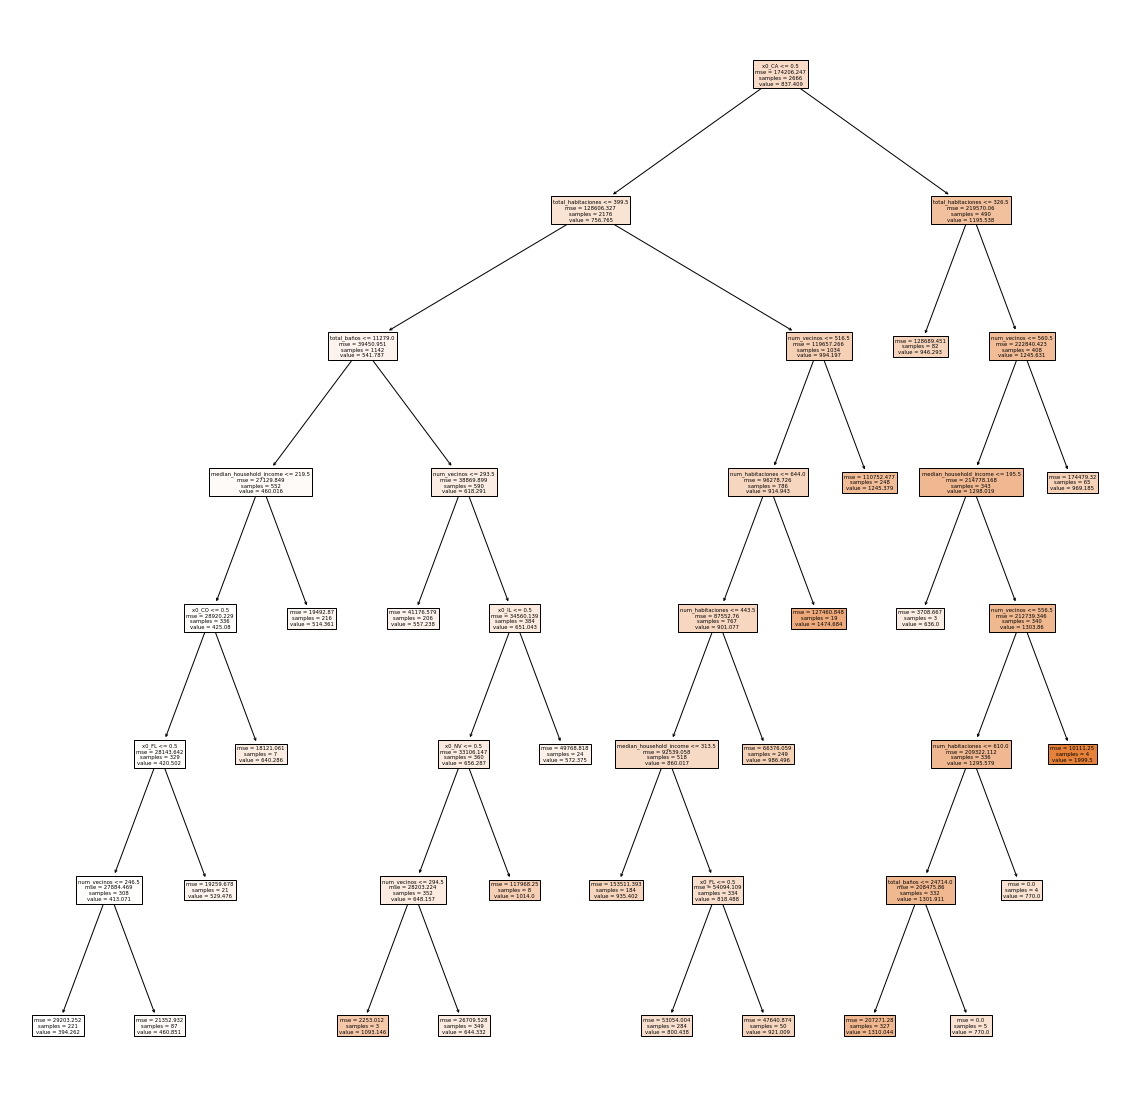

In [39]:
# volvamos a intentar visualizar el árbol a ver como se ve: 

fig = plt.figure(figsize=(20, 20))
tree.plot_tree(best_tree, feature_names=X_train.columns, filled=True);



In [40]:
# guardamos la imagen 

fig.savefig("decision_tree.png", facecolor="white")

In [41]:
y_pred_test_dt = best_tree.predict(X_test)
y_pred_train_dt = best_tree.predict(X_train)


In [42]:
dt_results = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decision tree")



In [43]:
dt_results



,MAE,MSE,RMSE,R2,modelo
test,206.394675,81990.118952,286.339168,0.523658,Decision tree
train,204.590715,80583.945275,283.873115,0.537422,Decision tree


**Comparemos la regresión lineal con el random Forest**

In [44]:
df_all = pd.concat([lr_results, dt_results], axis = 0).reset_index()
df_all.rename(columns = {"index": "set"}, inplace = True)
df_all



,set,MAE,MSE,RMSE,R2,modelo
0,test,209.683355,94927.542353,308.103136,0.448495,Regresion lineal
1,train,207.269152,91563.791337,302.595095,0.474394,Regresion lineal
2,test,206.394675,81990.118952,286.339168,0.523658,Decision tree
3,train,204.590715,80583.945275,283.873115,0.537422,Decision tree


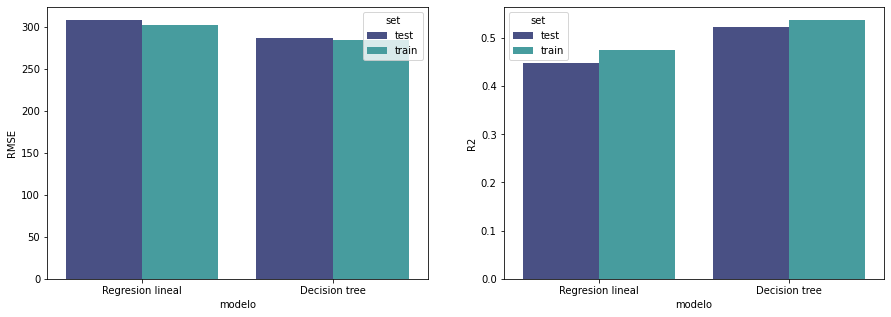

In [45]:
fig, axes = plt.subplots(1,2, figsize =(15,5))

sns.barplot(df_all.modelo, df_all.RMSE, hue = df_all.set, ax = axes[0], palette="mako")
sns.barplot(df_all.modelo, df_all.R2, hue = df_all.set, ax = axes[1], palette = "mako");



### Importancia de cada variable

In [46]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': regressor.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
0,median_household_income,0.077118
1,num_habitaciones,0.089675
2,num_vecinos,0.324386
3,total_habitaciones,0.146473
4,total_baños,0.097735
5,dist_playa,0.058463
6,x0_AL,0.002250
7,x0_AR,0.001817
8,x0_AZ,0.002276
9,x0_CA,0.125694


Tanto la variable género como la de estado estaban categorizadas y nos aparecen tantas filas como categorías teníamos. Lo que tenemos que hacer ahora es juntar cada una de esas categorías y sumar sus valores. 

In [47]:
# lo primero que hacemos es crearnos un dataframe con los valores solo de género
genero = pd.DataFrame(importancia_predictores.iloc[-2:])
genero

,predictor,importancia
34,x1_F,0.009280
35,x1_M,0.003289


In [48]:
# hacemos lo mismo para estados
estado = pd.DataFrame(importancia_predictores.loc[6:33, ])
estado.head(2)

,predictor,importancia
6,x0_AL,0.002250
7,x0_AR,0.001817


In [49]:
# eliminamos esas filas del dataframe donde tenemos los valores de importancia

importancia_predictores.drop(genero.index, inplace = True)
importancia_predictores.drop(estado.index, inplace = True)

In [50]:
# nos creamos nuevas filas con el resultado de la suma

importancia_predictores.loc[6] =  ["estado", estado["importancia"].sum()]
importancia_predictores.loc[7] =  ["genero", genero["importancia"].sum()]

In [51]:
# ordenamos los resultados

importancia_predictores.sort_values( ascending=False, by= "importancia", inplace=True)
importancia_predictores

,predictor,importancia
2,num_vecinos,0.324386
6,estado,0.193581
3,total_habitaciones,0.146473
4,total_baños,0.097735
1,num_habitaciones,0.089675
0,median_household_income,0.077118
5,dist_playa,0.058463
7,genero,0.012569


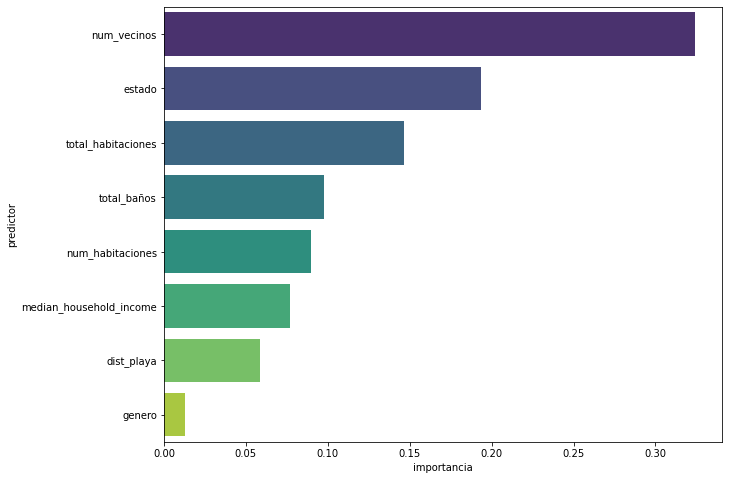

In [52]:
#y por último los ploteamos

sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");